In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToPILImage
import torch.multiprocessing as mp
import wandb
import imageio
import cv2
import gradio as gr
import pytorch_lightning as pl
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [2]:
class Config:
    RUNTIME = "KAGGLE"
    SUBSET_FRACTION = None
    NUM_EPOCHS = 30
    BATCH_SIZE = 64
    PRECISION = "16-mixed"
    LOG_EVERY_N_STEPS = 10
    INPUT_IMAGE_SIZE = (45, 45)    
    DIM_Z = 100
    NUM_WORKERS = mp.cpu_count()
    EARLY_STOPPING_PATIENCE = 6  # Add this line for early stopping patience
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SchedulerConfig:
    # for ReduceLROnPlateau (number of epochs with no improvement after which the learning rate will be reduced)
    SCHEDULER_PATIENCE = 5  
    # for ReduceLROnPlateau (factor by which the learning rate will be reduced)
    FACTOR = 0.5 
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts (Number of epochs before the first restart)
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts (Minimum learning rate)
    T_mult = 1 # for CosineAnnealingWarmRestarts (Factor by which Ti(number of epochs between two restarts) increases)
    MAX_LR = 1e-3 # for CosineAnnealing (Initial learning rate)
    STEPS_PER_EPOCH = 13 # for OneCycleLR
    STEP_SIZE = 10 # for StepLR
    GAMMA = 0.5 # for StepLR

In [3]:
class VAENetwork(nn.Module):
    def __init__(self, dim_z):
        super().__init__()
        self.dim_z = dim_z
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z * 2),  # Output mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 45*45*3)
        )

    def encode(self, x):
        x = x.view(-1, 45*45*3)
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar[:, :self.dim_z], mu_logvar[:, self.dim_z:]  # Split into mean and log variance
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        decoded = self.decoder(z)
        decoded = decoded.view(-1, 3, 45, 45)
        return decoded
    
    def forward(self, x):        
        mu, logvar = self.encode(x) 
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        decoded = self.decode(z)        
        return decoded, mu, logvar  # Return decoded output, mean, and log variance

In [4]:
# Loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
class VAE(pl.LightningModule):
    def __init__(self, config, scheduler_config):
        super(VAE, self).__init__()
        self.config = config
        self.scheduler_config = scheduler_config
        self.network = VAENetwork(config.DIM_Z)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs = batch
        outputs, mu, logvar = self(inputs)
        loss = vae_loss(outputs, inputs, mu, logvar)
        self.log('train_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch
        outputs, mu, logvar = self(inputs)
        loss = vae_loss(outputs, inputs, mu, logvar)
        mse = vae_loss(outputs, inputs, mu, logvar)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('val_loss', loss, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_mse', mse, on_epoch=True, logger=True, prog_bar=True)
        self.log('cur_lr', current_lr, prog_bar=True, on_epoch=True, logger=True)
        return {'val_loss': loss, 'inputs': inputs, 'outputs': outputs}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.scheduler_config.MAX_LR)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=self.scheduler_config.STEP_SIZE, 
            gamma=self.scheduler_config.GAMMA
        )
        return [optimizer], [scheduler]

In [6]:
# # Load model state dictionary
# state_dict = torch.load('./data/vae_faces.ckpt', map_location='cuda:0')
# # Create model instance with same architecture
# model = VAE(Config, SchedulerConfig)
# model.load_state_dict(state_dict['state_dict'])
# model.eval()

In [7]:
model = VAENetwork(Config.DIM_Z)
model_checkpoint = torch.load("./data/VAE.pth", weights_only=True)
model.load_state_dict(model_checkpoint)
model.eval()

VAENetwork(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=1500, bias=True)
    (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1500, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=1500, bias=True)
    (4): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1500, out_features=6075, bias=True)
  )
)

In [8]:
latent_vectors = torch.randn(1, Config.DIM_Z)
with torch.no_grad():
    decoded_images = model.decode(latent_vectors)
decoded_images

tensor([[[[-0.5045, -0.5252, -0.5734,  ..., -0.3169, -0.3930, -0.4296],
          [-0.5146, -0.5285, -0.5498,  ..., -0.3417, -0.4292, -0.4874],
          [-0.5391, -0.5977, -0.5628,  ..., -0.3271, -0.4203, -0.5164],
          ...,
          [-0.8065, -0.9052, -0.9827,  ..., -0.6038, -0.5783, -0.6416],
          [-0.7368, -0.8381, -0.9632,  ..., -0.6755, -0.6765, -0.7052],
          [-0.7045, -0.8334, -0.8724,  ..., -0.6544, -0.6722, -0.6982]],

         [[-0.6366, -0.7748, -0.8362,  ..., -0.9660, -1.0369, -1.0395],
          [-0.7011, -0.7386, -0.8565,  ..., -1.0106, -1.0666, -1.0728],
          [-0.7738, -0.8276, -0.8491,  ..., -1.0289, -1.0702, -1.1504],
          ...,
          [-0.9063, -0.9627, -1.1128,  ..., -1.2290, -1.2192, -1.2029],
          [-0.8079, -0.9453, -1.0888,  ..., -1.2891, -1.2496, -1.2048],
          [-0.7922, -0.8571, -0.9804,  ..., -1.3130, -1.2878, -1.2209]],

         [[-1.1191, -1.2157, -1.3470,  ..., -1.8038, -1.7808, -1.7715],
          [-1.1224, -1.2644, -

In [9]:
# get the max and min values of the decoded image
decoded_image = decoded_images.squeeze(0)
decoded_image_max = decoded_image.max()
decoded_image_min = decoded_image.min()
print(decoded_image_max, decoded_image_min)

tensor(0.8900) tensor(-2.2478)


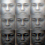

In [13]:
decoded_image = decoded_images.squeeze(0)
decoded_image = decoded_image.view(45, 45, 3).detach().numpy()
decoded_image = (decoded_image - decoded_image.min()) / (decoded_image.max() - decoded_image.min())
decoded_image = (decoded_image * 255).astype(np.uint8)
decoded_image = Image.fromarray(decoded_image)
decoded_image.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.247803..0.889975].


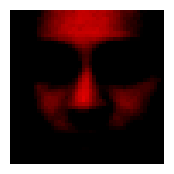

In [17]:
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(decoded_images[0].permute(1, 2, 0).cpu().detach().numpy())
# ax.imshow(decoded_image)
ax.axis('off')
#plt.tight_layout()
plt.show()

In [148]:
# cv2.imshow("Decoded Image", decoded_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [32]:
# Define a function to generate a random face
def generate_random_face():
    model.eval()
    with torch.no_grad():
        # Sample a random latent vector
        z = torch.randn(1, Config.DIM_Z)  # Assuming latent dimension of 100
        generated_image = model.decode(z)
        generated_image = generated_image.squeeze(0)        
        # Convert the output tensor (image) to PIL format for display
        image = generated_image.permute(1, 2, 0).detach().cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())
        # resize the image to 45x45
        image = cv2.resize(image, (90, 90))
        return image

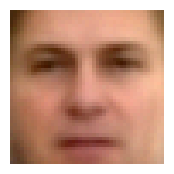

In [52]:
random_image = generate_random_face()
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(random_image)
ax.axis('off')
plt.show()

In [55]:
# Create a Gradio interface
iface = gr.Interface(
    fn=generate_random_face,  # The function to call
    inputs=None,  # No inputs, just generates random images
    # outputs="image",  # Output is an image
    outputs=gr.Image(height=250, width=250),
    title="VAE Random Face Generator",
    description="Generates random faces using a trained Variational Autoencoder (VAE)."
)

# Launch the Gradio interface
iface.launch(inline=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
